# Quantifying the World
### Case Study 10 - Missing Data Imputation Using Boston Housing Dataset
#### Kelly Carter, Swee K Chew, Vlad Orlov, Anjli Solsi

## Introduction

Most of the datasets inevitably contain missing data and in most cases, those missing values are excluded from the analysis. This can limit the amount of information available, especially if the dataset contains many inputs with missing values, and could potentially bias the results. Thus, one should impute missing data prior to modeling or doing any forms of analysis.

The goal of this case study is to learn about the different types of missing data mechanism and how each of the mechanism could impact the data imputation and bias the results. The three missing data mechanisms we focus on this case study are as follows: 

- Missing Completely at Random (MCAR)
- Missing at Random (MAR)
- Missing Not at Random (MNAR)

For the imputation of missing data, we will use the Boston Housing dataset available in Sklearn.

## Background

**Missing Completely at Random (MCAR)** indicates that there is no relationship between the missingness of the data and any observed or missing values. The propensity for a data point to be missing is completely random, some data are not more likely to be missing than others [1]. 

**Missing at Random (MAR)** suggests that there is a systematic relationship between the propensity of missing values and the observed data. In other words, whether an observation is missing is not related to the missing values, but it is related to the values of an observed variable. For example, when weight information is missing for women more than men as men are more likely to reveal their weight than women. 

**Missing Not at Random (MNAR)** implies that there is a relationship between the propensity of a value to be missing and its values. For example, when education field is missing for the people with the lowest education. 

One important consideration in choosing a missing data approach is the missing data mechanism since different approaches have different assumptions about the mechanism. For an instance, *Multiple Imputation* and *Maximum Likelihood* require the data are at least missing at random. *Listwise deletion* assumes the data are MCAR in order to not introduce bias in the results. 

In most data sets, it is likely that more than one variable will have missing data and they may not all have the same missing data mechanism. It will be worthwhile to diagnose the mechanism for each variable with missing data before choosing an approach. Sometimes, there is no definitive answer and we may have to choose the mechanism in a number of ways and then decide if the assumptions we made are reasonable [1].

## Methods

In this analysis, we will first fit a linear regressor to the Boston Housing data in order to obtain a baseline. We will calcuate the loss and use the goodness of fit parameters (AIC, MSE, and $R^{2}$), which will serve as our baseline for comparison. We will first use the MCAR mechanism to replace the present value with a NaN for 1, 5, 10, 20, 33, and 50% of the data within a single column selected at random. For each set of missing data, we will perform an imputation of the missing value using three methods (by finding the mean, median and mode of the variable). We will then perform a fit with the imputed data for each case and compare the loss and goodness of fit to the baseline. 

Next, we will use the MAR mechanism to create missing data. We will take two different columns at random and create three sets of missing data (10, 20, and 30% missing) while controlling for a third variable. We will then perform an imputation of the missing values for each set, fit the imputed data and compare the results to the baseline. 

Finally, we will create a dataset in which 25% of the data is missing for a single column using the MNAR mechanism. Similarly, we will impute the missing data, fit the results and compare them to the baseline. 

## Analysis


We begin by fetching the Boston Housing data using sklearn. Descriptions for all attributes can be found below. It should be noted that the description for *MEDV* applies to the *PRICE* attribute found within the dataset itself. The prompts for four tasks are provided in italics.

In [1]:
import random
import numpy as np
import pandas as pd  

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.impute import SimpleImputer

import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
boston = load_boston()

In [4]:
# View the data descriptions
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Per the data descriptions, the Boston Housing data contains 506 observations with 14 variables. The last variable, *MEDV* or *PRICE* is the target variable. The original dataset does not contain any missing attribute values. 

In [5]:
# Display the first 5 observations
bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
# Display the stats for all the variables
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Step 1: Baseline Model

***Using Sklearn get the Boston Housing dataset.
Fit a linear regressor to the data as a baeline.  There is no need to do Cross-Validation.  We are exploring the change in results. In each case perform a fit with the imputed data and compare the loss and goodness of fit to your baseline.***

Here, we will first fit a linear regression using our training data and then create functions to calculate the AIC, MSE, and $R^{2}$ which will be used to evaluate the goodness of fit for the regression.

In [7]:
def calculate_aic(model, X, y):
    """Calculates Akaike Information Criterion
    (see https://machinelearningmastery.com/probabilistic-model-selection-measures/)"""
    mse = mean_squared_error(y, model.predict(X))
    num_params = len(model.coef_) + 1
    n = len(y)
    aic = n * np.log(mse) + 2 * num_params
    return aic

In [8]:
def fit_and_evaluate_lm(X, y):
    """
    Fits Linear Regression model. Calculates AIC, R2 and Median Absolute Error
    """
    # Create train and test splits from the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=5)    
    # Perform Linear Regression
    base_model = LinearRegression()
    base_model.fit(X_train, Y_train)
    #evaluate goodness of fit and loss,
    #let's use both metrics, because median_absolute_error is less sensitive to outliers
    return {
        "R2_score": base_model.score(X_test, Y_test),
        "Mean_Squared_Error": mean_squared_error(Y_test, base_model.predict(X_test)),
        "AIC": calculate_aic(base_model, X_test, Y_test)
    }

In [9]:
base_model_results = fit_and_evaluate_lm(boston.data, boston.target)
base_model_results

{'R2_score': 0.7334492147453092,
 'Mean_Squared_Error': 20.869292183770682,
 'AIC': 337.90443811267414}

Based on the results above, we will use the $R^{2}$ score of 0.73, MSE measure of 20.87, and AIC measure of 337.90 as our baseline of fit for comparison in the later sections.

### Step 2: Use of MCAR

***Select 1, 5 10, 20, 33, and 50% of your data on a single column (Completely at random), replace the present value with a NAN and then perform an imputation of that value.***

***In each case perform a fit with the imputed data and compare the loss and goodness of fit to your baseline.***

First, we will create a function that will appropriately choose a column at random and randomly replace a specific percentage of data values with a NaN based on provided input.

For the 6 percentage values provided, we use the 3 imputation methods (mean, median, and mode) and calculate the same goodness of fit measures calculated for the baseline model in Step 1.

In [10]:
def nans_at_random(X, column_idx, percentage_nan):
    """Replace values of X with a NAN completely at random"""
    X = X.copy()
    for i in range(X.shape[0]):
        if np.random.rand() < percentage_nan:
            X[i, column_idx] = np.nan
    return X    

In [11]:
percentages = [.01, .05, .1, .2, .33, .5]
imputation_methods = ['Mean', 'Median', 'Mode']

completely_at_random_results = {}
for m in imputation_methods:
    for p in percentages:
        column_index = np.random.randint(0, boston.data.shape[1] - 1)    
        data = nans_at_random(boston.data, column_index, p)
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')    
        results = fit_and_evaluate_lm(imp_mean.fit_transform(data), boston.target)
        completely_at_random_results[f'{m}_{p*100:.0f}%'] = results
        
completely_at_random_results['baseline'] = base_model_results        

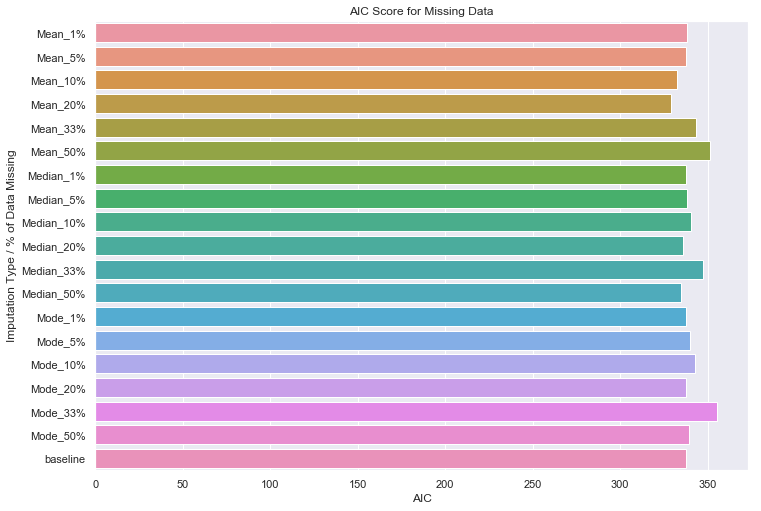

In [12]:
ax = sns.barplot(y=list(completely_at_random_results.keys()),
            x=list(map(lambda x: x['AIC'], completely_at_random_results.values())))
_ = ax.set(title='AIC Score for Missing Data', xlabel='AIC', ylabel='Imputation Type / % of Data Missing')

<center>Figure 1: AIC Measures for Missing at Random Imputation on a Single Column</center>

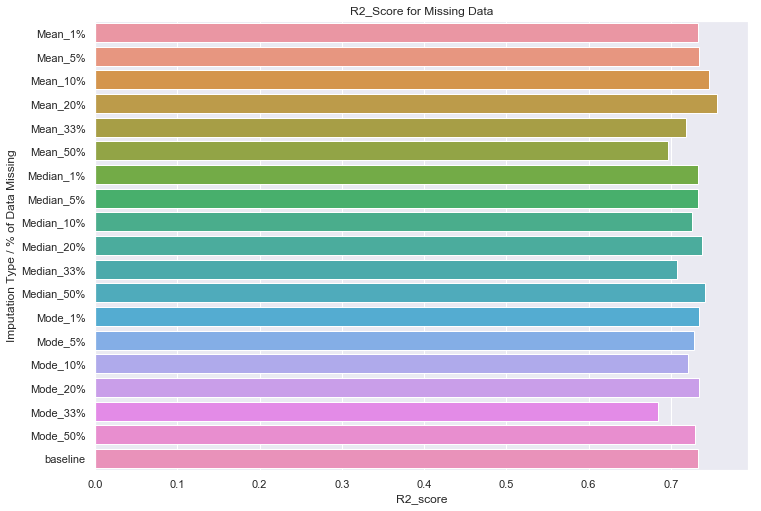

In [13]:
ax = sns.barplot(y=list(completely_at_random_results.keys()),
            x=list(map(lambda x: x['R2_score'], completely_at_random_results.values())))
_ = ax.set(title='R2_Score for Missing Data', xlabel='R2_score', ylabel='Imputation Type / % of Data Missing')

<center>Figure 2: $R^{2}$ Scores for Missing at Random Imputation on a Single Column</center>

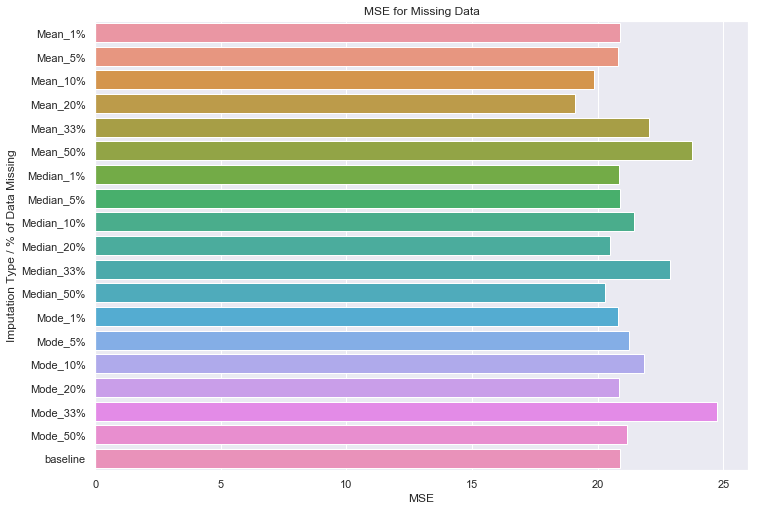

In [14]:
ax = sns.barplot(y=list(completely_at_random_results.keys()),
            x=list(map(lambda x: x['Mean_Squared_Error'], completely_at_random_results.values())))
_ = ax.set(title='MSE for Missing Data', xlabel='MSE', 
           ylabel='Imputation Type / % of Data Missing')

<center>Figure 3: MSE Measures for Missing at Random Imputation on a Single Column</center>

Figure 1-3 displays the AIC, $R^{2}$, and MSE values, respectively, for the baseline and each of the imputation type and percentage of missing data combination. Here, we are imputing the missing values for a randomly selected columm, as to experiment MCAR.

For the 18 regression functions fitted using the imputed data for a single column, we do not notice any significant performance degradation in any of our goodness of fit measures. The goodness of fit measure that has the most fluctuation is MSE, but this is still minimal and only noticeable for a small portion of our fitted regressions.

### Step 3: Use of MAR

***Take 2 different columns and create data “Missing at Random” when controlled for a third variable (i.e if Variable Z is > 30, than Variables X, Y are randomly missing).  Make runs with 10%, 20% and 30% missing data imputed via your best guess. In each case perform a fit with the imputed data and compare the loss and goodness of fit to your baseline.*** 

Here, we create a function similar to the one created in Step 2, but this one additionally requires input for a control column. A value in a random column is replaced with NaN if the value in the control column is below the control column mean; this is run until the percentage of NaN values supersedes the provided percentage. Our imputation method is then altered to run twice such that we are removing data from two fields as prompted. Again, we are ensuring that the control column and imputed columns are chosen at random.

For the 3 percentage values provided, we again use the 3 imputation methods and calculate the same goodness of fit measures calculated for the baseline model in Step 1.

In [15]:
def nans_at_random_with_control(X, column_idx, control_column, percentage_nan, ):
    """Replace values of X with a NAN completely at random when controlled for a third variable"""
    mean = np.mean(X[:, control_column])
    X = X.copy()
    for i in range(X.shape[0]):
        if np.random.rand() < percentage_nan and X[i, control_column] < mean:
            X[i, column_idx] = np.nan
    return X 

In [16]:
percentages = [.1, .2, .3]
imputation_methods = ['Mean', 'Median', 'Mode']

at_random_results_with_control = {}
for m in imputation_methods:
    for p in percentages:
        indexes = list(range(0, boston.data.shape[1] - 1))
        column_index1 = random.choice(indexes) 
        indexes.remove(column_index1)
        column_index2 = random.choice(indexes)
        indexes.remove(column_index2)
        control_column = random.choice(indexes)        
        data = nans_at_random_with_control(boston.data, column_index1, control_column, p)
        data = nans_at_random_with_control(data, column_index2, control_column, p)
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')    
        results = fit_and_evaluate_lm(imp_mean.fit_transform(data), boston.target)
        at_random_results_with_control[f'{m}_{p*100:.0f}%'] = results
        
at_random_results_with_control['baseline'] = base_model_results        

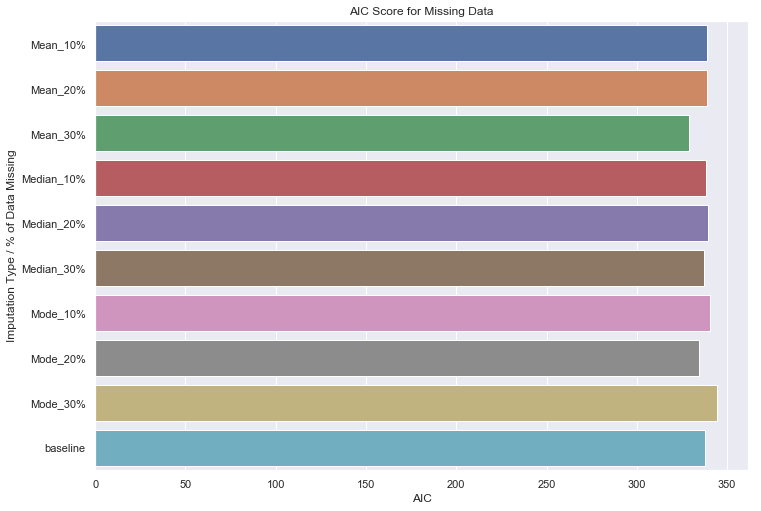

In [17]:
ax = sns.barplot(y=list(at_random_results_with_control.keys()),
            x=list(map(lambda x: x['AIC'], at_random_results_with_control.values())))
_ = ax.set(title='AIC Score for Missing Data', xlabel='AIC', ylabel='Imputation Type / % of Data Missing')

<center>Figure 4: AIC Measures for Missing at Random Imputation on Two Columns When Controlled for a Third Variable</center>

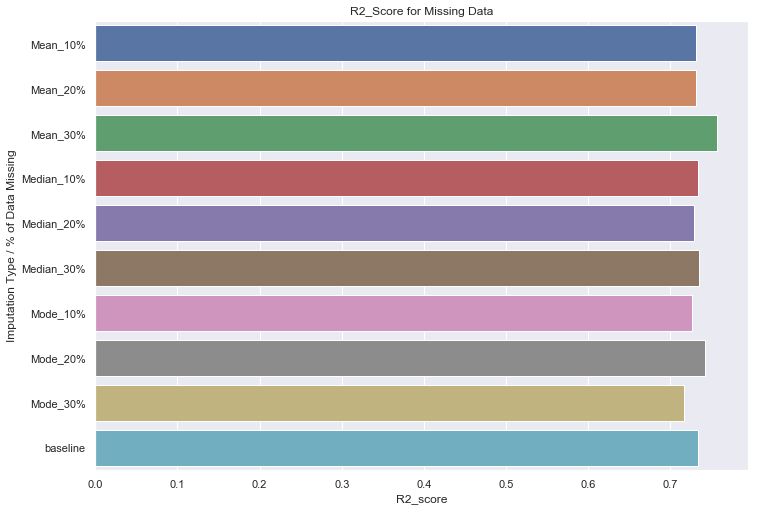

In [18]:
ax = sns.barplot(y=list(at_random_results_with_control.keys()),
            x=list(map(lambda x: x['R2_score'], at_random_results_with_control.values())))
_ = ax.set(title='R2_Score for Missing Data', xlabel='R2_score', ylabel='Imputation Type / % of Data Missing')

<center>Figure 5: $R^{2}$ Scores for Missing at Random Imputation on Two Columns When Controlled for a Third Variable</center>

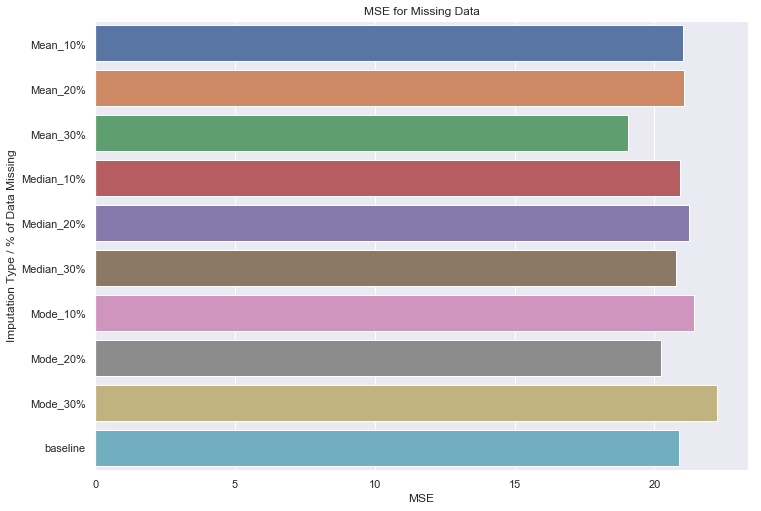

In [19]:
ax = sns.barplot(y=list(at_random_results_with_control.keys()),
            x=list(map(lambda x: x['Mean_Squared_Error'], at_random_results_with_control.values())))
_ = ax.set(title='MSE for Missing Data', xlabel='MSE', 
           ylabel='Imputation Type / % of Data Missing')

<center>Figure 6: MSE Measures for Missing at Random Imputation on Two Columns When Controlled for a Third Variable</center>

Figure 4-6 displays the AIC, $R^{2}$, and MSE values, respectively, for the baseline and each of the imputation type and percentage of missing data combination. Here, we are imputing the missing values for two randomly selected columms while controlling for a third variable, as to experiment MAR. 

As in step 2, we do not noticed any significant performance degradation in any of the metrics used to measure the goodness of fit and once again the measure experiencing the most fluctuation is MSE.

### Step 4: Use of MNAR

***Create a Missing Not at Random pattern in which 25% of data is missing for a single column. Impute your data, find the results and compare to a baseline***

Here, we create a function that replaces the first 25% of rows with a NaN value for a chosen column. This is then applied to a column at random. We then calculate our goodness of fit measures as we have in previous steps.

In [20]:
def nans_not_at_random(X, column_idx, percentage_nan):
    """Replace first N rows of X with a NAN"""
    pos = int(X.shape[0] * percentage_nan)
    X = X.copy()
    X[:pos] = np.nan
    return X 

In [21]:
percentages = [.25]
imputation_methods = ['Mean', 'Median', 'Mode']

not_at_random_results = {}
for m in imputation_methods:
    for p in percentages:
        column_index = random.choice(list(range(0, boston.data.shape[1] - 1))) 
        data = nans_not_at_random(data, column_index, p)
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')    
        results = fit_and_evaluate_lm(imp_mean.fit_transform(data), boston.target)
        not_at_random_results[f'{m}_{p*100:.0f}%'] = results
        
not_at_random_results['baseline'] = base_model_results        

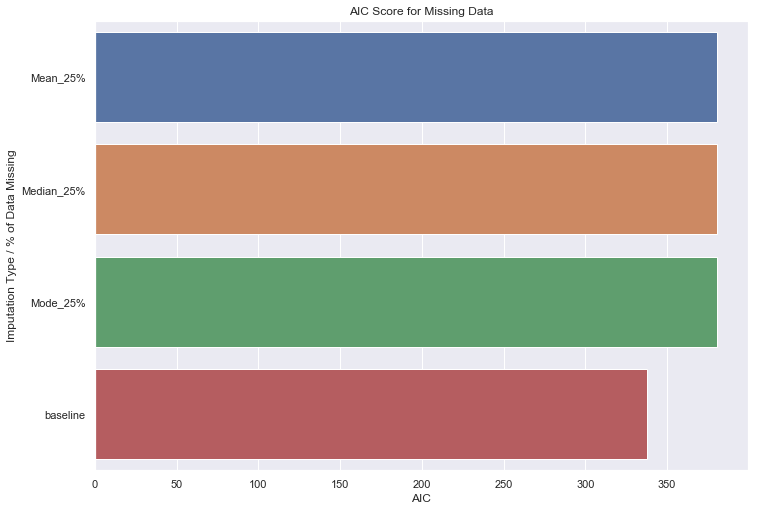

In [22]:
ax = sns.barplot(y=list(not_at_random_results.keys()),
            x=list(map(lambda x: x['AIC'], not_at_random_results.values())))
_ = ax.set(title='AIC Score for Missing Data', xlabel='AIC', ylabel='Imputation Type / % of Data Missing')

<center>Figure 7: AIC Measures for Missng Not at Random Imputation on a Single Column</center>

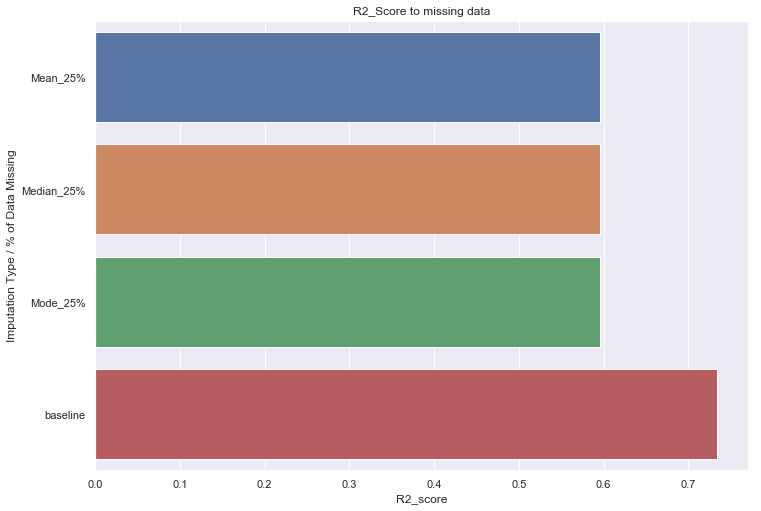

In [23]:
ax = sns.barplot(y=list(not_at_random_results.keys()),
            x=list(map(lambda x: x['R2_score'], not_at_random_results.values())))
_ = ax.set(title='R2_Score to missing data', xlabel='R2_score', ylabel='Imputation Type / % of Data Missing')

<center>Figure 8: $R^{2}$ Scores for Missng Not at Random Imputation on a Single Column</center>

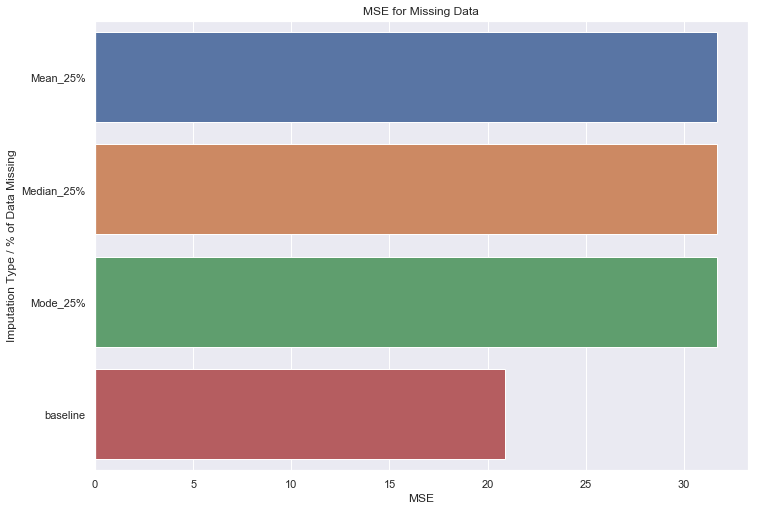

In [24]:
ax = sns.barplot(y=list(not_at_random_results.keys()),
            x=list(map(lambda x: x['Mean_Squared_Error'], not_at_random_results.values())))
_ = ax.set(title='MSE for Missing Data', xlabel='MSE', 
           ylabel='Imputation Type / % of Data Missing')

<center>Figure 9: MSE Measures for Missng Not at Random Imputation on a Single Column</center>

Figure 7-9 shows the AIC, $R^{2}$, and MSE values, respectively, for the baseline and each of the imputation type and percentage of missing data combination. Here, we are imputing the missing values on the first 25% of the data on a randomly selected variable, as to experiment MNAR. 

This time there is a noticeable degradation in performance for all 3 imputation methods when compared to their respective baseline model. It should additionally be noted that we received almost the same results for all three imputation methods across all three measures of fit. For example, the $R^{2}$ value is ~0.6 whether we use the mean, median, or mode to impute the missing data. Further analysis should be completed to determine if the results are consitent when using a different variable.

## Conclusion 

As previously mentioned, MCAR and MAR mechanisms found only slight degradation on overall performance, especially if MSE is used, whereas the MNAR mechanism experienced noticeable degradation. Additionally, for both the MCAR and MAR mechanisms, the percentage of data missing did not seem to have a noticeable effect on overall performance. In order to get more insight into overall goodness of fit, further analysis should be completed by examining the effects on a single column at a time to determine if some columns are more susceptible to missing data than others. Additionally, looking at the overall distribution of each column would provide insight as columns that more closely resemble a normal distribution would have better performance.

### Sources

[1] https://www.theanalysisfactor.com/missing-data-mechanism/

[2] https://medium.com/@haydar_ai/learning-data-science-day-9-linear-regression-on-boston-housing-dataset-cd62a80775ef

[3] https://machinelearningmastery.com/probabilistic-model-selection-measures/